## save the Keras model

In [33]:
KERAS_MODEL_PATH = "model/spec_model_np_1.keras"

In [34]:
model.save(KERAS_MODEL_PATH)

## Size of the keras model

In [35]:
# Function to get the file size
def get_and_convert_file_size(file_path, unit=None):
    size = os.path.getsize(file_path)
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [36]:
keras_model_size = get_and_convert_file_size(KERAS_MODEL_PATH, 'MB')

File size: 1.356 Megabytes


## TFLite Model for model

In [47]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model/spec_model_np_1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmp3bdxd0jl\assets


INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmp3bdxd0jl\assets


In [48]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model/spec_model_np_1.tflite')
interpreter.allocate_tensors()

In [49]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 128   1]


In [50]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 5]


In [51]:
# Prepare the test dataset 
test_mel_spec_ds = test_mel_spec_ds.unbatch().batch(1)

In [52]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for mel_spectrogram, label in test_mel_spec_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [55]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 90%


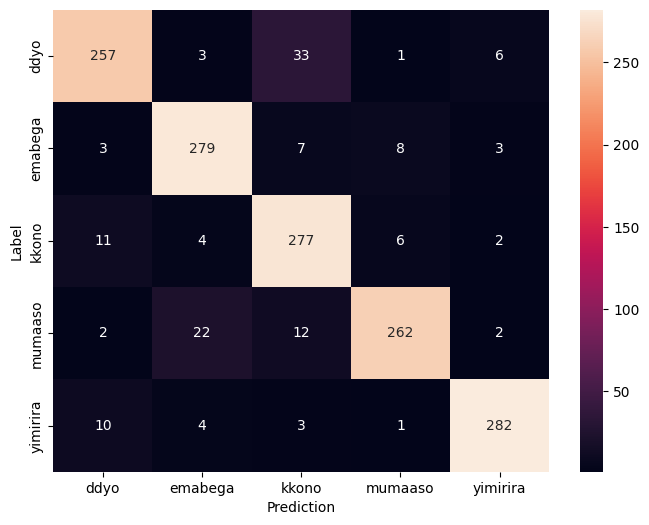

In [56]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [57]:
get_and_convert_file_size('model/spec_model_np_1.tflite', "KB")

File size: 450.992 Kilobytes


## Quntized model

In [58]:
# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model/Quantized_spec_model_np_1.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmphxsz_0ke\assets


INFO:tensorflow:Assets written to: C:\Users\vX\AppData\Local\Temp\tmphxsz_0ke\assets


In [59]:
get_and_convert_file_size('model/Quantized_spec_model_np_1.tflite', "KB")

File size: 122.258 Kilobytes


In [60]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for mel_spectrogram, label in test_mel_spec_ds:
    interpreter.set_tensor(input_details[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.9046666666666666


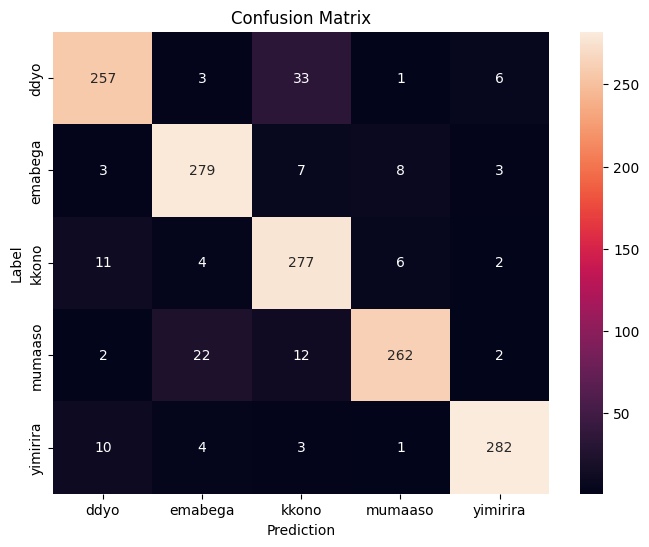

In [61]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for mel_spectrogram, label in test_mel_spec_ds:
    interpreter.set_tensor(input_details[0]['index'], mel_spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [62]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 90%
